# RNNs for onset detection

We saw that hand-crafted features can do the job.
But can we improve upon this simple solution?

Instead of manually designing features, learn them!


In [1]:
from __future__ import print_function, division


import numpy as np
import tensorflow as tf
import keras
import madmom
import pickle
import warnings

Using TensorFlow backend.


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

RNN training is often faster if run on CPU only, thus disabling GPU support:

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

Define some globel parameters:

In [4]:
FPS = 100
ONSET_PATH = 'onsets_ISMIR_2012/'

### Dataset handling

We assume the data directory structure to be as follows:

- `audio/` contains all audio files,
- `annotations/` contains various annotations, e.g. onsets, beats, etc., each of them in a separate sub-directory,
- `splits/` contains predefined splits.

We define a `Dataset`, which has the following fucntionality:

- features, annotations and corresponding filenames are stored as a list,
- method to load and/or pre-process data,
- method to load and parse the annotations, 
- method for handling pre-define file splits for cross-validation.


In [5]:
class Dataset(object):
    
    def __init__(self, path, audio_suffix='.wav', annotation_suffix='.onsets'):
        self.path = path
        # populate lists containing audio and annotation files
        audio_files = madmom.utils.search_files(self.path + '/audio', audio_suffix)
        annotation_files = madmom.utils.search_files(self.path + '/annotations', annotation_suffix, recursion_depth=1)
        # match annotation to audio files
        self.files = []
        self.audio_files = []
        self.annotation_files = []
        for annotation_file in annotation_files:
            # search matching audio file
            matches = madmom.utils.match_file(annotation_file, audio_files, suffix=annotation_suffix, match_suffix=audio_suffix)
            if len(matches) == 1:
                audio_file = matches[0]
                self.audio_files.append(audio_file)
                self.annotation_files.append(annotation_file)
                # save the base name
                self.files.append(os.path.basename(annotation_file[:-len(annotation_suffix)]))
            else:
                warnings.warn('skipping %s, no audio file found' % annotation_file)
                             
        
    def load_splits(self, path=None, fold_suffix='.fold'):
        path = path if path is not None else self.path + '/splits'
        self.split_files = madmom.utils.search_files(path, fold_suffix, recursion_depth=1)
        # populate folds
        self.folds = []
        for i, split_file in enumerate(self.split_files):
            fold_idx = []
            with open(split_file) as f:
                for file in f:
                    file = file.strip()
                    # get matching file idx
                    try:
                        idx = self.files.index(file)
                        fold_idx.append(idx)
                    except ValueError:
                        # file could be not available, e.g. in Ballrom set a few duplicates were found
                        warnings.warn('no matching audio/annotation files: %s' % file)
                        continue
            # set indices for fold
            self.folds.append(np.array(fold_idx))
            
    def pre_process(self, pre_processor):
        self.x = [pre_processor(file) for file in self.audio_files]
        
    def load_annoatations(self, widen=None):
        self.annotations = [madmom.io.load_onsets(file) for file in self.annotation_files]


Create a `Dataset`:

In [6]:
onsets_db = Dataset(ONSET_PATH, audio_suffix='.flac')
onsets_db.load_annoatations()
onsets_db.load_splits()

### Feature pre-processing

Rely on a feature representation, which is known to work.

We could use a single FFT size, but let's make it a bit more sophisticated and use 3 stacked spectrograms with different FFT sizes and filters with a different number of filters (bands) per octave.

Define a callable processor:

In [7]:
from madmom.processors import ParallelProcessor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor
        
# define pre-processor
class OnsetPreProcessor(SequentialProcessor):

    def __init__(self, frame_sizes=[1024, 2048, 4096], num_bands=[3, 6, 12]):
        # resample to a fixed sample rate in order to get always the same number of filter bins
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # process multi-resolution spec & diff in parallel
        multi = ParallelProcessor([])
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            # split audio signal in overlapping frames
            frames = FramedSignalProcessor(frame_size=frame_size)
            # compute STFT
            stft = ShortTimeFourierTransformProcessor()
            # filter the magnitudes
            filt = FilteredSpectrogramProcessor(num_bands=num_bands)
            # scale them logarithmically
            spec = LogarithmicSpectrogramProcessor()
            # stack positive differences
            diff = SpectrogramDifferenceProcessor(positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # instantiate a SequentialProcessor
        super(OnsetPreProcessor, self).__init__((sig, multi, np.hstack))

# create a callable pre-processor
pp = OnsetPreProcessor()

Pre-process the audio files (i.e. extract features).

In [ ]:
onsets_db.pre_process(pp)

Alternatively, pre-computed features can be loaded from file.
[They can can be downloaded here](https://drive.google.com/file/d/1yTlqRoseNdFa1_jpXyUrOO6bH-7wtPXE/view?usp=sharing) (size: 732 MB).
Please place the pickle file in the same directory as this notebook or adjust the following command.

In [9]:
onsets_db = pickle.load(open('onset_db.pkl', 'rb'))

Save them as a pickle, so we don't have to re-compute them.

In [ ]:
pickle.dump(onsets_db, open('onset_db.pkl', 'wb'))

### Sequence handling for NN training

Wrap a `Dataset` as a generator we can iterate over. It provides the following functionality:

- convert annotations to targets usable for training
- return pre-processed features and corresponding targets based on the given batch size
- able to limit the maximum sequence length

must return
- a tuple `(inputs, targets)`
- a tuple `(inputs, targets, sample_weights)`

In [10]:
from keras.utils import Sequence

class DataSequence(Sequence):
    
    mask_value = -999  # only needed for batch sizes > 1

    def __init__(self, x, y, batch_size=1, max_seq_length=None, fps=FPS):
        self.x = x
        self.y = [madmom.utils.quantize_events(o, fps=fps, length=len(d))
                  for o, d in zip(y, self.x)]
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        # determine which sequence(s) to use
        x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # pad them if needed
        if self.batch_size > 1:
            x = keras.preprocessing.sequence.pad_sequences(
                x, maxlen=self.max_seq_length, dtype=np.float32, truncating='post', value=self.mask_value)
            y = keras.preprocessing.sequence.pad_sequences(
                y, maxlen=self.max_seq_length, dtype=np.int32, truncating='post', value=self.mask_value)
        return np.array(x), np.array(y)[..., np.newaxis]
    

To be able to create a `DataSequence` which contains only the correct (non-verlapping) splitting of the files, we define a simple helper class which returns the indices of the files used for training/validation/testing.

In [11]:
class Fold(object):
    
    def __init__(self, folds, fold):
        self.folds = folds
        self.fold = fold
        
    @property
    def test(self):
        # fold N for testing
        return np.unique(self.folds[self.fold])
        
    @property
    def val(self):
        # fold N+1 for validation
        return np.unique(self.folds[(self.fold + 1) % len(self.folds)])
        
    @property
    def train(self):
        # all remaining folds for training
        train = np.hstack((onsets_db.folds))
        train = np.setdiff1d(train, self.val)
        train = np.setdiff1d(train, self.test)
        return train
            

## Train network

First define which sequences are used for training and validation, leave the files for testing untouched.

In [12]:
basedir = 'models/onsets/'

In [13]:
lr = 0.01
num_fold = 0

fold = Fold(onsets_db.folds, num_fold)

train = DataSequence([onsets_db.x[i] for i in fold.train],
                     [onsets_db.annotations[i] for i in fold.train],
                      batch_size=1, max_seq_length=60 * FPS)
                             
val = DataSequence([onsets_db.x[i] for i in fold.val],
                   [onsets_db.annotations[i] for i in fold.val],
                    batch_size=1, max_seq_length=60 * FPS)

In [14]:
example = 'vorbis_lalaw'
example_idx = onsets_db.files.index(example)

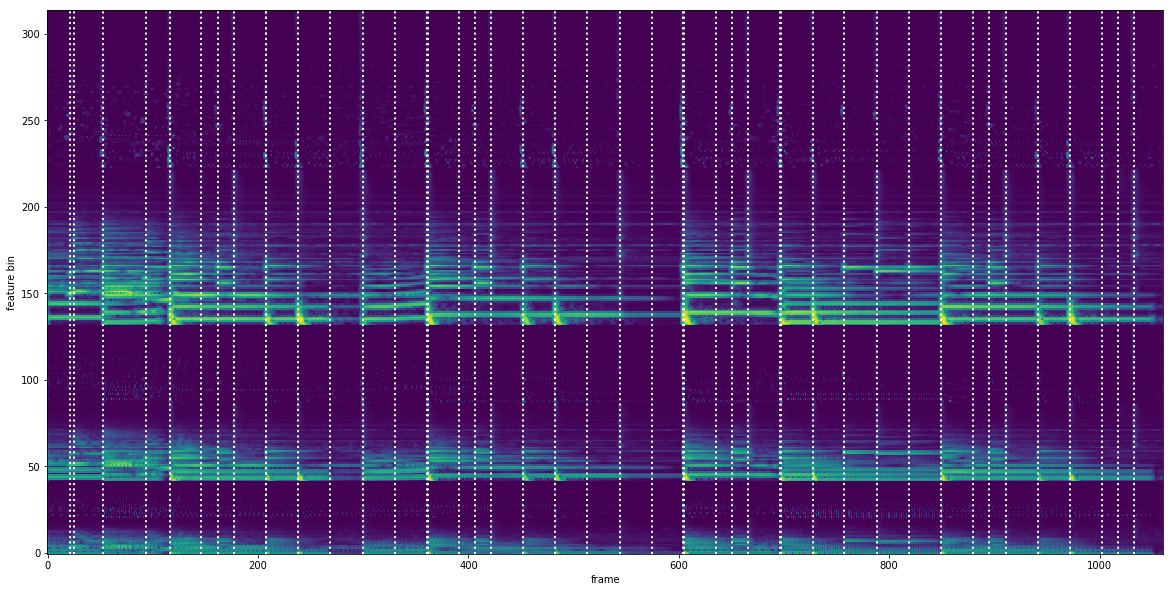

In [64]:
plt.imshow(onsets_db.x[example_idx].T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('feature bin')
for ann in onsets_db.annotations[example_idx]:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

Define a network and compile it.

As loss to minimise we use binary cross entropy since we have a binary classification problem and the classes are not balanced.

We use stochastic gradient descent (SGD) with momentum as our optimizer.

To avoid exploding gradients, we clip them at a certain value.

In [16]:
from keras.models import Sequential
from keras.layers import Input, SimpleRNN, Bidirectional, Masking, LSTM, Dense

In [17]:
model = Sequential()
model.add(Masking(input_shape=(None, train[0][0].shape[-1]), mask_value=train.mask_value))
model.add(Bidirectional(SimpleRNN(units=25, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=25, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=25, return_sequences=True)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=lr, clipvalue=5, momentum=0.9),
              metrics=['binary_accuracy'])

In Keras, callbacks can be defined. These are called during training at the end of each epoch to perform certain actions. We define some callbacks, to:

- save the best models (wrt. loss and validation loss) in order to predict and evaluate onsets on intermediate steps,
- stop training if no validation loss improvement is observed for a certain number of epochs,
- save log files (in Tensorboard format) to monitor the training progress.

In [18]:
verbose=0
name = '%s/lr_%s/fold_%s/' % (basedir, str(lr).replace('.', ''), str(fold.fold))

mca = keras.callbacks.ModelCheckpoint(name + 'model_{epoch:02d}.h5', monitor='loss', save_best_only=False, verbose=verbose)
mcb = keras.callbacks.ModelCheckpoint(name + 'model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)
mcv = keras.callbacks.ModelCheckpoint(name + 'model_best_val.h5', monitor='val_loss', save_best_only=True, verbose=verbose)
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=verbose)
tb = keras.callbacks.TensorBoard(log_dir=name + 'logs', write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


Finally start training of the network and save the final model when training finishes.
For each epoch, shuffle the order of the training sequences.

In [ ]:
history = model.fit_generator(train, steps_per_epoch=len(train), epochs=100, shuffle=True,
                              validation_data=val, validation_steps=len(val),
                              callbacks=[mca, mcb, mcv, es, tb])
model.save(name + 'model_final.h5')

Epoch 1/200
239/239 [==============================] - 182s 762ms/step - loss: 0.1841 - binary_accuracy: 0.9485 - val_loss: 0.1575 - val_binary_accuracy: 0.9521
Epoch 2/200
 19/239 [=>............................] - ETA: 2:33 - loss: 0.1645 - binary_accuracy: 0.9508

Train all models for all folds...

## Predict onsets on test set

... it is assumed that there are 8 trained models in oder to perform 8-fold cross validation.
For each trained model ~1/8 of the complete dataset was left for testing.
Now we use the 8 models to predict the onsets on these parts.

In [22]:
outdir = basedir + 'lr_%s_predictions/' % str(lr).replace('.', '')

In [27]:
try:
    os.mkdir(outdir)
except FileExistsError:
    pass

for i, f in enumerate(onsets_db.folds):
    model_name = '%s/lr_%s/fold_%s/model_best_val.h5' % (basedir, str(lr).replace('.', ''), i)
    print('testing', model_name)
    model = keras.models.load_model(model_name)
    for j in f:
        pred = model.predict(onsets_db.x[j][np.newaxis, ...]).squeeze()
        np.save('%s/%s.npy' % (outdir, onsets_db.files[j]), pred)

testing models/onsets//lr_001/fold_0/model_best_val.h5
testing models/onsets//lr_001/fold_1/model_best_val.h5
testing models/onsets//lr_001/fold_2/model_best_val.h5
testing models/onsets//lr_001/fold_3/model_best_val.h5
testing models/onsets//lr_001/fold_4/model_best_val.h5
testing models/onsets//lr_001/fold_5/model_best_val.h5
testing models/onsets//lr_001/fold_6/model_best_val.h5
testing models/onsets//lr_001/fold_7/model_best_val.h5


In [28]:
rnn_peak_picking = madmom.features.onsets.OnsetPeakPickingProcessor(
        threshold=0.35, pre_max=0.01, post_max=0.01, smooth=0.07, combine=0.03)

for f in madmom.utils.search_files(outdir, '.npy'):
    act = np.load(f)
    det = rnn_peak_picking(act)
    madmom.io.write_onsets(det, f[:-3] + 'onsets.txt')

## Evaluate onset predictions

In [29]:
def evaluate_onsets(predictions, annotations, verbose=False, ann_suffix='.onsets', det_suffix='.onsets.txt'):
    evals = []
    for ann in annotations:
        name = os.path.basename(ann)
        # get the matching detection files
        matches = madmom.utils.match_file(ann, detections, ann_suffix, det_suffix)
        det = madmom.io.load_onsets(matches[0])
        ann = madmom.io.load_onsets(ann)
        e = madmom.evaluation.onsets.OnsetEvaluation(
            det, ann, combine=0.03, window=0.025, name=name)
        evals.append(e)
        if verbose:
            print(e)
    se = madmom.evaluation.onsets.OnsetSumEvaluation(evals)
    me = madmom.evaluation.onsets.OnsetMeanEvaluation(evals)
    return se, me

In [30]:
detections = madmom.utils.search_files(outdir, '.onsets.txt')
annotations = madmom.utils.search_files(ONSET_PATH + '/annotations/onsets', '.onsets')

se, me = evaluate_onsets(detections, annotations)
print(se)
print(me)

sum for 321 files
  Onsets: 25827 TP: 21074 FP:  2065 FN:  4753 Precision: 0.911 Recall: 0.816 F-measure: 0.861 mean:   0.2 ms std:   6.2 ms
mean for 321 files
  Onsets: 80.46 TP: 65.65 FP:  6.43 FN: 14.81 Precision: 0.902 Recall: 0.845 F-measure: 0.862 mean:  -0.1 ms std:   5.5 ms


## Finetuning

After training finishes, we can perform finetuning of the parameters.
Therefore we load the previously best model (wrt. validation loss), reduce the learn rate by a factor of 10, and re-train for a couple of epochs.

In [ ]:
model = keras.models.load_model(name + 'model_best_val.h5')

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=lr / 10., clipvalue=5, momentum=0.9),
              metrics=['binary_accuracy'])

verbose=0
mca = keras.callbacks.ModelCheckpoint(name + 'model_retrain_{epoch:02d}.h5', monitor='loss', save_best_only=True, verbose=verbose)
mcb = keras.callbacks.ModelCheckpoint(name + 'model_retrain_best.h5', monitor='loss', save_best_only=True, verbose=verbose)
mcv = keras.callbacks.ModelCheckpoint(name + 'model_retrain_best_val.h5', monitor='val_loss', save_best_only=True, verbose=verbose)
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=verbose)
tb = keras.callbacks.TensorBoard(log_dir=name + 'retrain_logs', write_graph=True, write_images=True)

history = model.fit_generator(train, steps_per_epoch=len(train), epochs=20, shuffle=True,
                              validation_data=val, validation_steps=len(val),
                              callbacks=[mca, mcb, mcv, es, tb])
model.save(name + 'model_retrain_final.h5')

Epoch 1/20
239/239 [==============================] - 183s 767ms/step - loss: 0.0758 - binary_accuracy: 0.9728 - val_loss: 0.0820 - val_binary_accuracy: 0.9705
Epoch 2/20
106/239 [============>.................] - ETA: 1:36 - loss: 0.0751 - binary_accuracy: 0.9726

Re-train models for all folds...

... after re-training them, predict onsets

In [34]:
outdir = basedir + 'lr_%s_predictions_retrain/' % str(lr).replace('.', '')

In [38]:
try:
    os.mkdir(outdir)
except FileExistsError:
    pass

for i, f in enumerate(onsets_db.folds):
    model_name = '%s/lr_%s/fold_%s/model_retrain_best_val.h5' % (basedir, str(lr).replace('.', ''), i)
    model = keras.models.load_model(model_name)
    print('testing', model_name)
    for j in f:
        pred = model.predict(onsets_db.x[j][np.newaxis, ...]).squeeze()
        np.save('%s/%s.npy' % (outdir, onsets_db.files[j]), pred)

testing models/onsets//lr_001/fold_0/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_1/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_2/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_3/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_4/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_5/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_6/model_retrain_best_val.h5
testing models/onsets//lr_001/fold_7/model_retrain_best_val.h5


In [39]:
for f in madmom.utils.search_files(outdir, '.npy'):
    act = np.load(f)
    det = rnn_peak_picking(act)
    madmom.io.write_onsets(det, f[:-3] + 'onsets.txt')

In [40]:
detections = madmom.utils.search_files(outdir, '.onsets.txt')
annotations = madmom.utils.search_files(ONSET_PATH + '/annotations/onsets', '.onsets')

se, me = evaluate_onsets(detections, annotations)
print(se)
print(me)

sum for 321 files
  Onsets: 25827 TP: 21241 FP:  2066 FN:  4586 Precision: 0.911 Recall: 0.822 F-measure: 0.865 mean:   0.1 ms std:   6.2 ms
mean for 321 files
  Onsets: 80.46 TP: 66.17 FP:  6.44 FN: 14.29 Precision: 0.903 Recall: 0.851 F-measure: 0.867 mean:  -0.2 ms std:   5.5 ms


Finetuning of the network gives a small performance improvement (~0.5%).
The observed improvement depends on the dataset (e.g. it is greater for beat tracking).

### Bagging

Network bagging (i.e. averaging predictions of multiple networks) is an easy way to improve the quality of the predictions.

Assuming we trained two set of networks with two different learn rates (it is not important that the learn rate were different, simply that two training runs were done):

In [41]:
outdir = basedir + 'bagged_predictions_retrain/'

try:
    os.mkdir(outdir)
except FileExistsError:
    pass

lr_001 = madmom.utils.search_files(basedir + 'lr_001_predictions_retrain', '.npy')
lr_002 = madmom.utils.search_files(basedir + 'lr_002_predictions_retrain' , '.npy')


for f_1, f_2 in zip(lr_001, lr_002):
    # load the individual predictions
    pred_1 = np.load(f_1)
    pred_2 = np.load(f_2)
    pred = np.mean(np.c_[pred_1, pred_2], axis=1)
    np.save(outdir + os.path.split(f_1)[-1], pred)

In [42]:
peak_picking = madmom.features.onsets.OnsetPeakPickingProcessor(
        threshold=0.35, pre_max=0.01, post_max=0.01, smooth=0.07, combine=0.03)

for f in madmom.utils.search_files(outdir, '.npy'):
    act = np.load(f)
    det = peak_picking(act)
    madmom.io.write_onsets(det, f[:-3] + 'onsets.txt')

In [43]:
detections = madmom.utils.search_files(outdir, '.onsets.txt')
annotations = madmom.utils.search_files(ONSET_PATH + '/annotations/onsets', '.onsets')

se, me = evaluate_onsets(detections, annotations)
print(se)
print(me)

sum for 321 files
  Onsets: 25827 TP: 21425 FP:  2091 FN:  4402 Precision: 0.911 Recall: 0.830 F-measure: 0.868 mean:   0.1 ms std:   6.1 ms
mean for 321 files
  Onsets: 80.46 TP: 66.74 FP:  6.51 FN: 13.71 Precision: 0.901 Recall: 0.858 F-measure: 0.870 mean:  -0.2 ms std:   5.5 ms


Bagging network gives another small performance improvement (~0.5%).
However, this technique has the disadvantage of requiring multiple training/prediction runs.

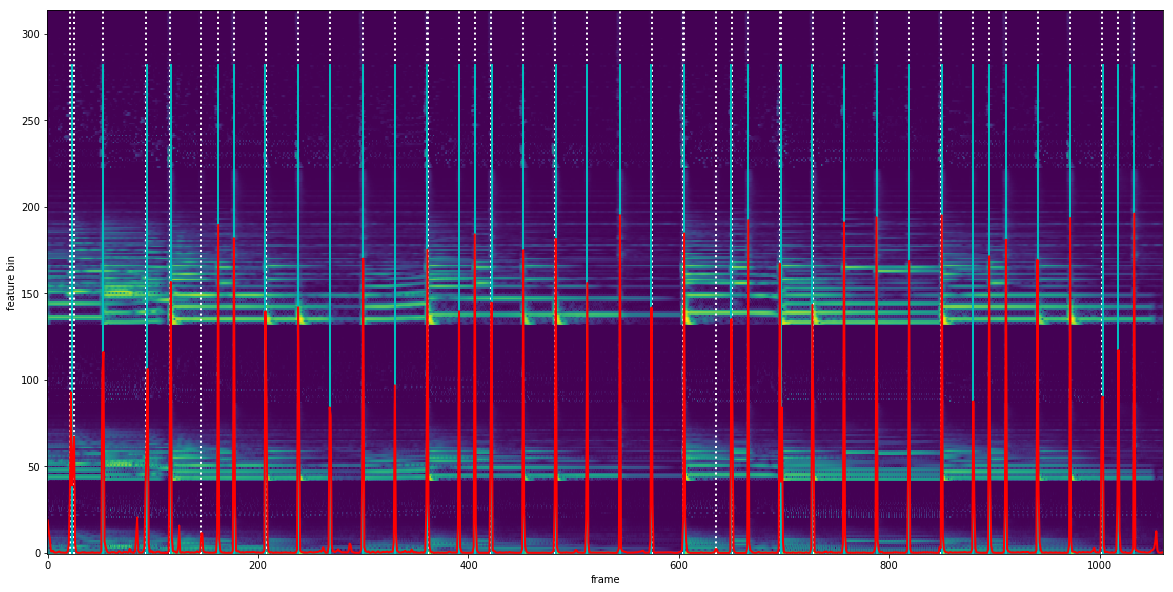

In [72]:
plt.imshow(onsets_db.x[example_idx].T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('feature bin')

for ann in onsets_db.annotations[example_idx]:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)
    
for o in madmom.io.load_onsets(detections[-1]) * FPS:
    plt.axvline(o, color='c', ymax=.9, linestyle='-', linewidth=2)

act = madmom.utils.search_files(basedir + 'bagged_predictions_retrain' , '%s.npy' % example)[0]
plt.plot(np.load(act) * 200, 'r', linewidth=2)

Possible variations for network training

- use other optimisers (e.g. Adam)
- use learn rate schedulers (e.g. cyclic learn rates)
- use mini batches (please note that shuffling of sequences must be performed inside the `DataSequence` class by implementing a `on_epoch_end` method)